I am training in Google Colab so the first two cells are reponsible for mounting my Google drive and setting the Colab working directory to the folder I'm using in Drive for the project.

In [1]:
#mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#setting my working directory to the folder I'm using in Google Drive
import os

#set root directory to Google Drive directory
root_dir = "/content/drive/My Drive/"

#choose project folder
project_folder = "Projects/water_bodies_segmentation/"

def create_and_set_working_directory(project_folder):
  """
    Args:
      project_folder: The folder to use as the project directory.

    Creates the project folder if it doesn't exist in Google Drive
    and sets the notebook's working directory to that folder.
  """
  # check if project folder exists, create if not
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)
  print(f'Changed working directory to {root_dir+project_folder}')

create_and_set_working_directory(project_folder)

Changed working directory to /content/drive/My Drive/Projects/water_bodies_segmentation/


<h1>Introduction </h1>

In this project we will segment bodies of water in satelite images using a convolutional neural network based on the U-Net architecture. The dataset we are working with contains image and mask pairs from satellite imagery, and our model's task will be to segment bodies of water that are in the images. 

<br> 

We will convert our images into Tensorflow tensors and explore our dataset before preparing our data for the model which is created using the functional API in our build_model module. This will involve loading the images as tensors in a Tensorflow datasets, scaling the tensors, as well as resizing and padding them. 

<br> 

Then we will prepare train, validation, and test sets before training our model for 100 epochs with early stopping and learning rate reduction. Finally we will evaluate our model on test data using a mean Intersection over Union, or IoU.

<br>

Many of the functions we will use are defined in utils and are TF functions to improve performance.

<br> 

The U-Net Architecture our model is based on is known for its U shape. It consists of two main paths, the left path is known as the contracting path, or encoder, and is a three tiered convolutional network that captures the image, the right path is referred to as the expansive path, or decoder, and has three upsampling convolutional layers that expand the low resolution features into a high resolution tensor. The two paths are joined by two central convolution layers.

In [4]:
!pip install tensorflow_addons

In [5]:
from build_model import get_unet
import datetime as dt
from functools import partial
from keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tqdm.auto import tqdm
from tensorflow import keras
import tensorflow_addons as tfa
from utils import find_mean_img_dimensions,load_img_and_mask,split_dataset,scale_values,resize_and_pad,display_img_mask_tensors

In [6]:
DATA_PATH = os.getcwd() + '/data/'
IMAGE_PATH = DATA_PATH + 'images/'
MASK_PATH = DATA_PATH + 'masks/'
MODEL_PATH = os.getcwd() + '/models/'

In [7]:
#retrieve filenames for the images (masks and corresponding images have identical names)
filenames = os.listdir(IMAGE_PATH)

<h1>Exploratoratory Analysis </h1>

In [8]:
#print number of images in our dataset
num_images = len(filenames)
print(f'Number of Images: {num_images}')

Number of Images: 2841


First we willl find the mean height and width of images in our dataset using find_mean_img defined in utils, it just loads each image in OpenCV and calculates the mean dimensions. When we resize the images we will use this to guide or decision. 

In [9]:
# find the mean height and width of our images
(mean_height, mean_width) = find_mean_img_dimensions(IMAGE_PATH,filenames)

  0%|          | 0/2841 [00:00<?, ?it/s]

In [10]:
print(f'Mean Height: {mean_height}')
print(f'Mean Width: {mean_width}')

Mean Height: 560.6652587117212
Mean Width: 445.2555438225977


Next we will display three random images from our dataset to get a feel for the images and masks that we are working with. We will use load_img_and_mask which is defined in utils, and accepts the path to an image directory, path to a the mask's directory, and the filename which is the same for the images and masks in this dataset. It returns a tuple containing the image and mask as tensors.
We will also use this function later to load the images as tensors in our dataset. 

In [ ]:
#group three examples together
n_examples = 3
examples = [load_img_and_mask(IMAGE_PATH,
                              MASK_PATH,
                              filenames[random.randrange(len(filenames))]) \
            for i in range(n_examples)]

In [ ]:
#print the first tensor to get an idea of the shape and dimensionality of our data
print(examples[0])

(<tf.Tensor: shape=(118, 106, 3), dtype=uint8, numpy=
array([[[  0,   7,  16],
        [  0,   8,  14],
        [  0,   2,   9],
        ...,
        [  1,   1,   3],
        [  0,   0,   2],
        [  0,   0,   2]],

       [[  0,   3,  12],
        [  0,   2,  11],
        [  0,   3,   9],
        ...,
        [103, 103, 105],
        [  0,   0,   2],
        [  0,   0,   2]],

       [[  0,   3,  12],
        [  0,   6,  14],
        [ 13,  26,  32],
        ...,
        [103, 102, 107],
        [  0,   0,   2],
        [  0,   0,   2]],

       ...,

       [[  0,   1,   6],
        [  0,   2,   7],
        [104, 107, 116],
        ...,
        [105, 117, 117],
        [100, 110, 112],
        [ 99, 111, 111]],

       [[  0,   1,   6],
        [  0,   2,   7],
        [104, 107, 116],
        ...,
        [  0,   3,   2],
        [  0,   4,   6],
        [  0,   5,   4]],

       [[  1,   2,   7],
        [  0,   2,   7],
        [104, 107, 116],
        ...,
        [  5,  14,  

We can see that the first tensor has the shape (380, 241, 3) which represents the height, width, and number of channels, which is 3 as images are in RGB.

<br>

The mask tensor contains a single channel in contrast and has the shape (380, 241, 1) where 380 is the mask's height, 241 its the width, and 1 represents its number of channels. Once we resize and pad our images and masks later the tensors will have a unfiform dimensions. 

Now we will display the three examples which were randomly sampled from the dataset using matplotlib.

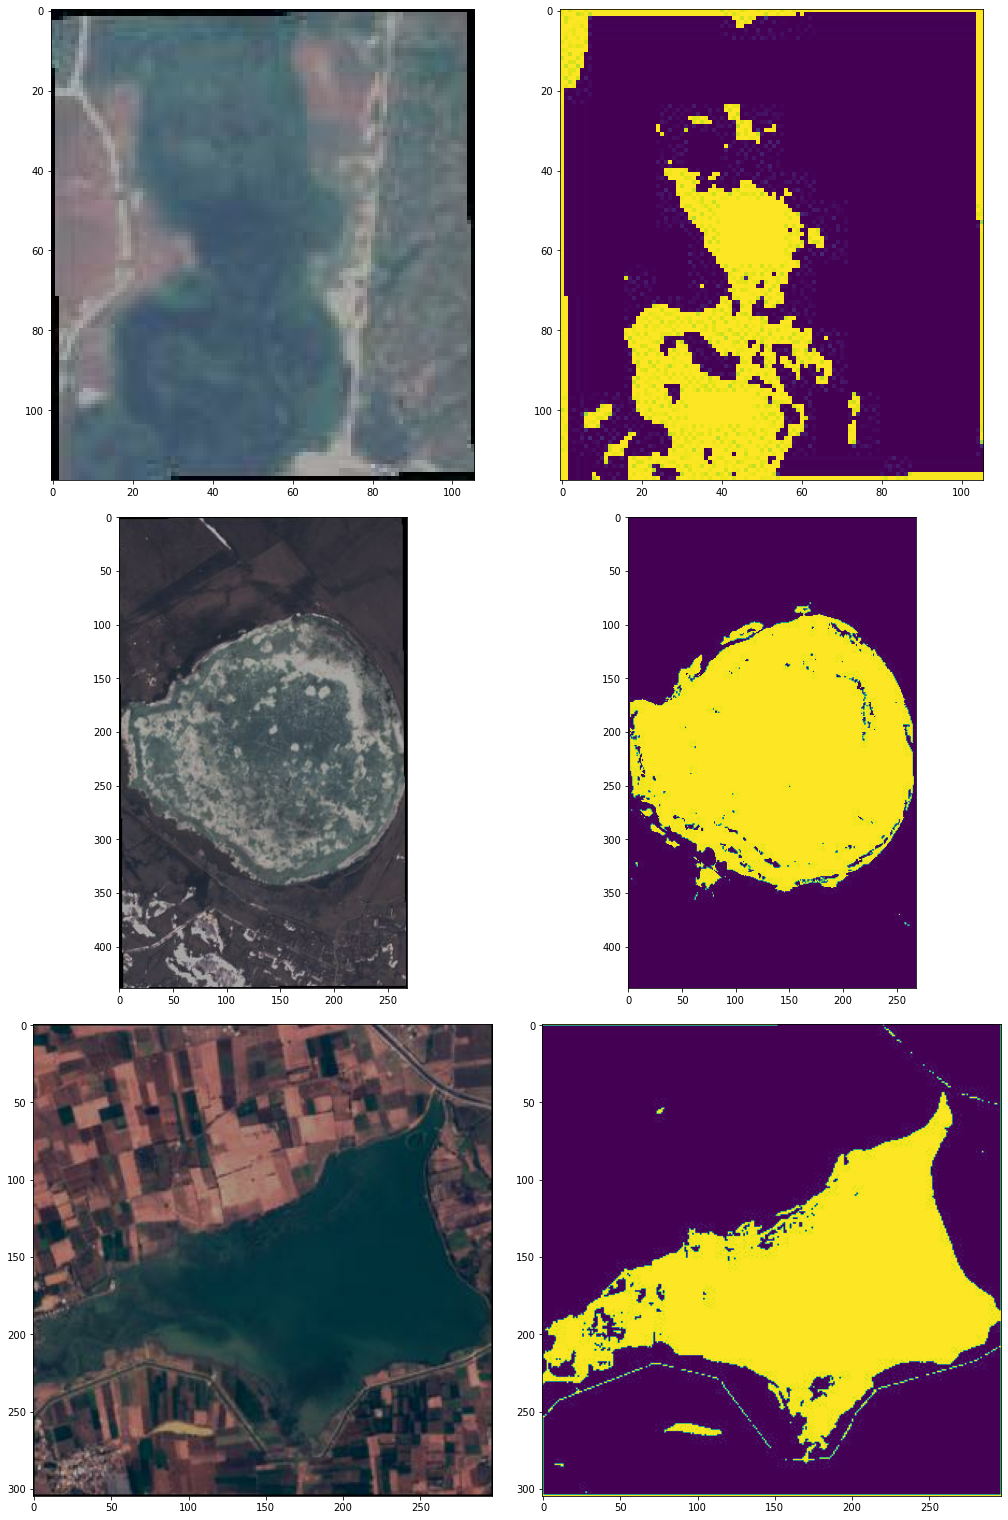

In [ ]:
#because the mask contains a single channel we must call tf.squeeze on the mask which will remove all dimensions with size=1
fig, axes = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axes, examples):
    mask = tf.squeeze(mask)
    ax[0].imshow(image)
    ax[1].imshow(mask)

Next we will create plots showing the RGB values of our sample images and corresponding masks, I was curious to see what the values would look like for each color.

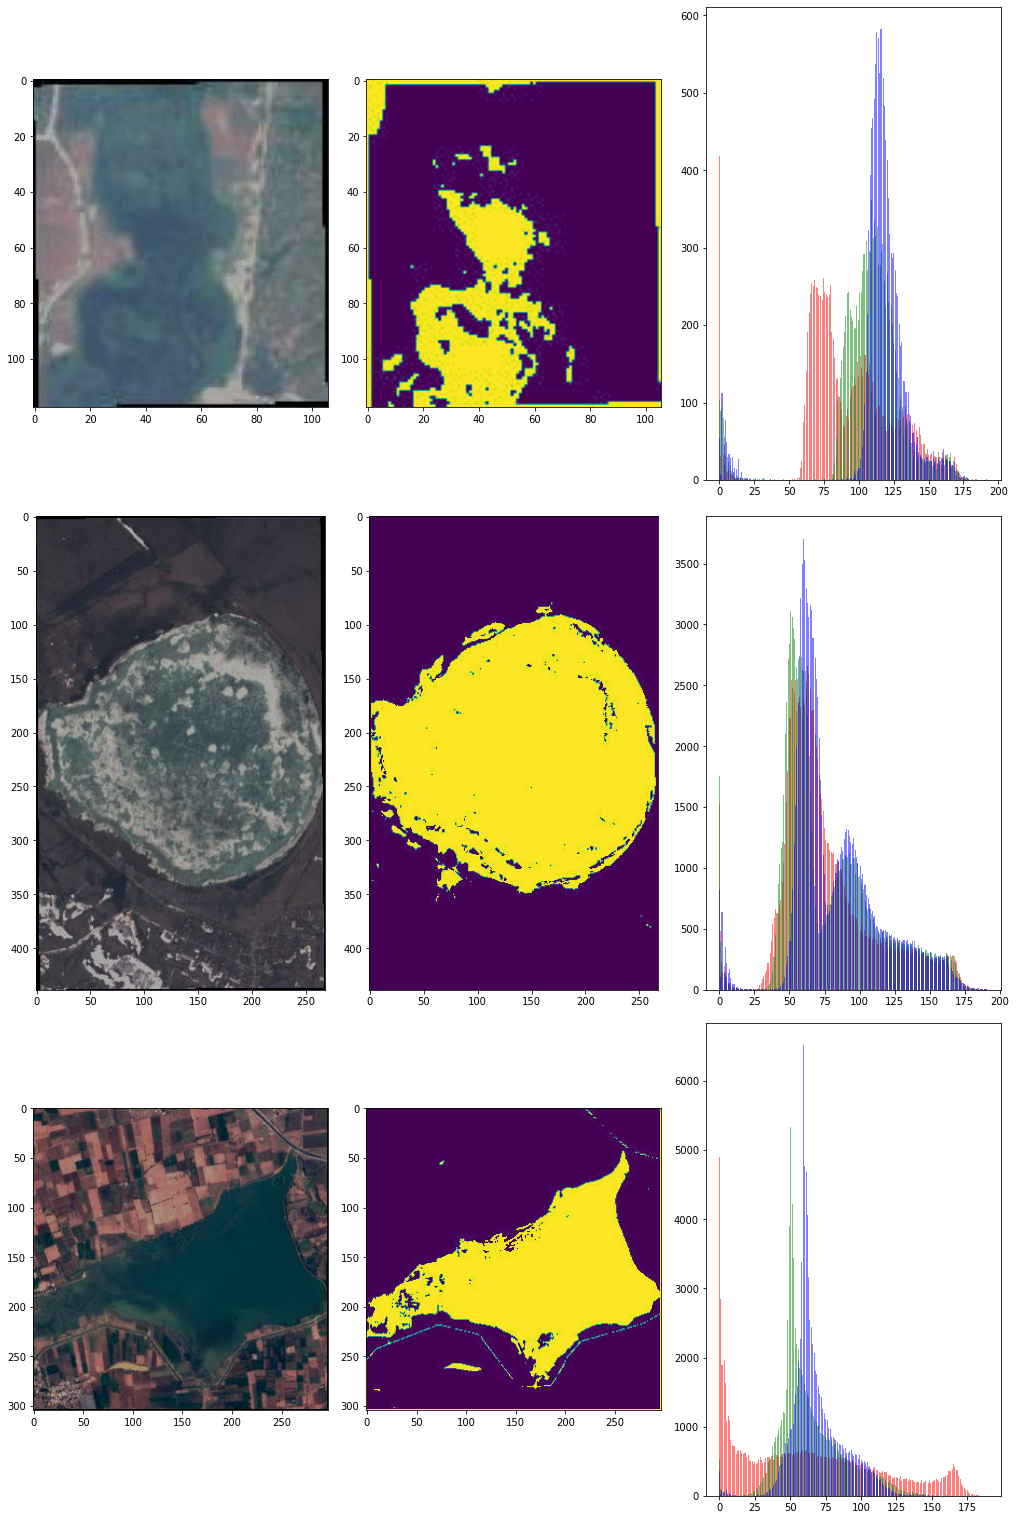

In [ ]:
fig, axes = plt.subplots(n_examples, 3, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axes, examples):
  image = np.array(image)
  mask = tf.squeeze(mask)
  ax[0].imshow(image)
  ax[1].imshow(mask)
  ax[2].hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
  ax[2].hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
  ax[2].hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)

<h1>Prepare Data </h1>

Now that we have an overview of the data we're working with and some general information about it we are ready to preprocess and transform the images, and prepare train, test, and validation sets for our model.
<br>

We will:
*   create a Tensorflow dataset for our images
*   reshape our images to have uniform dimensions
*   standardize our RGB values to fit in the [0,1] range
*   create train, test, and validation sets



We load images and their masks based on the filenames into a Tensorflow dataset using the load_img_and_mask function we saw earlier.
<br>

Then we will scale the images and masks, and then resize and pad the them using Tensorflow functions defined in utils. We will resize the images to 512 by 512 based on the mean dimensions we found earlier. 

In [11]:
RANDOM_STATE = 42 #used to split dataset into train,val,test
TARGET_HEIGHT = 512 #target height to resize images to
TARGET_WIDTH = 512 #target width to resize images to




#create TF dataset from filenames
dataset = tf.data.Dataset.from_tensor_slices(filenames)

#use our load_img_and_mask function to load each image and mask into the dataset
dataset = dataset.map(lambda x: load_img_and_mask(IMAGE_PATH,
                                                  MASK_PATH,
                                                  filename=x))
#scale the images to fit within the scale [0,1] and replaces any values that are not binary in the masks with 1 or 0 based on the threshold of 128
dataset = dataset.map(scale_values)

#resizes and pads the images to the target height and target width that we found earlier 
dataset = dataset.map(lambda image, mask: resize_and_pad(image, mask, target_height=TARGET_HEIGHT,target_width=TARGET_WIDTH))

Now we will display three tensors from our dataset after processing to see what they look like. 

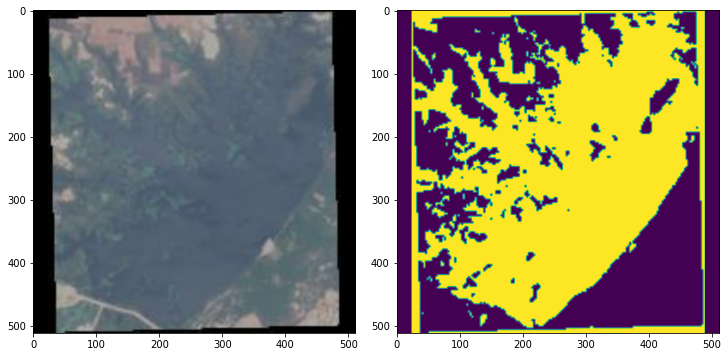

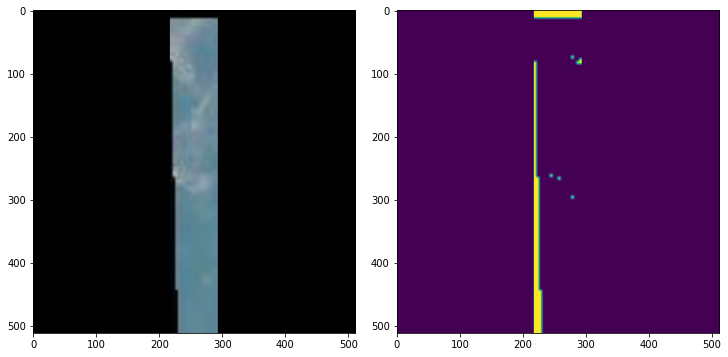

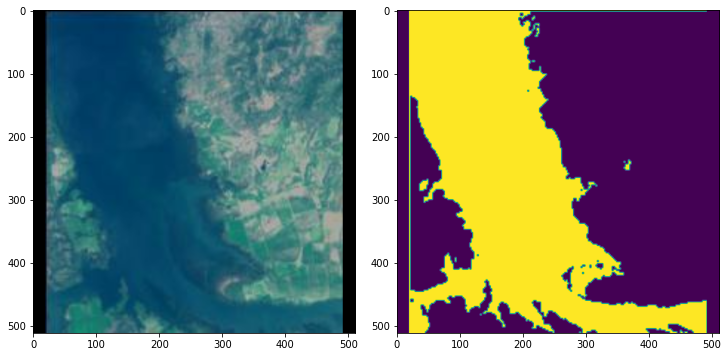

In [12]:
#display three images from the dataset to see what they look like after processing
n_examples = 3
for samples in dataset.take(n_examples):
  display_img_mask_tensors(samples)

Everything looks good so we will now create train, validation, and test sets for our model.

In [13]:
 #split dataset into train test and validation sets
train_dataset,val_dataset,test_dataset = split_dataset(dataset, num_images, 
                                                       shuffle_size=num_images,
                                                       seed=RANDOM_STATE)
train_dataset = train_dataset.batch(1).prefetch(5)
val_dataset = val_dataset.batch(1).prefetch(5)
test_dataset = test_dataset.batch(1).prefetch(5)

In [14]:
#ensure the dataset shapes look correct
print(f'Original Set: {dataset}')
print(f'Training Set: {train_dataset}')
print(f'Validation Set: {val_dataset}')
print(f'Testing Set: {test_dataset}')

Original Set: <MapDataset shapes: ((512, 512, 3), (512, 512, 1)), types: (tf.float32, tf.float32)>
Training Set: <PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>
Validation Set: <PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>
Testing Set: <PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>


<h1>Create Model </h1>

Next we will create our model using the functional API and the get_unet function defined in our build_model module. This will create a CNN with an architecture based on U-Net. 

<br>

As mentioned before the left path of the model is known as the contracting path, or encoder, and is a three tiered convolutional network that captures the image using three stacks consisting of two Conv2D layers and a max pooling layer, the right path or decoder has three upsampling convolutional layers formed by an UpSampling2D layer and Conv2D layers, which are responsible for expandindg the low resolution features into a high resolution tensor. The two paths are joined by two central Conv2D layers.

<br>

Our model will train for 100 epochs or until early stopping is implemented, and we will save the model that performs best on validation data. Furthermore, we will reduce the learning rate by half when the model's validation loss doesn't improve for three epochs. 

<br>

We will use the Nadam optimizer with the default learning rate, which is a variant of the popular Adam optimizer with Nesterov accelerated momentum. We will reduce the learning rate if the model plateaus for 2 epochs.

<br> 
We will monitor loss and accuracy as the model trains, when it is done training we will measure the Mean Intersection over Union or IoU, on test data, which is a common measure of performance for segmentation models.


In [15]:
#create model
model = get_unet()
#define optimizer
optimizer = tf.keras.optimizers.Nadam()
#compile model
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics = ["accuracy"])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9248        ['conv2d[0][0]']                 
                                32)                                                           

Next we will define our callbacks: 

*   checkpoint will be used to save the model with the best validation loss.
*   early_stopping will stop training when the model doesn't improve for 6 epochs.
*   lr_reduce will reduce the learning rate when the model doesn't improve for 2 epochs.
*   tqdm_callback simply displays a nice progress bar during training.

In [17]:
checkpoint = ModelCheckpoint(filepath = MODEL_PATH + f'U-NET/model_{dt.datetime.now().strftime("%Y-%m-%d--%H:%M:%S")}_best.h5', 
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

callbacks = [checkpoint,
             early_stopping,
             lr_reduce,
             tqdm_callback]

In [18]:
EPOCHS = 100
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=callbacks)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/2272           ETA: ?s - 

Epoch 1/100
2272/2272 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.7585
Epoch 00001: val_loss improved from inf to 0.41309, saving model to /content/drive/My Drive/Projects/water_bodies_segmentation/models/U-NET/model_2021-11-18--04:49:33_best.h5
2272/2272 [==============================] - 333s 67ms/step - loss: 0.4896 - accuracy: 0.7585 - val_loss: 0.4131 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 2/100


0/2272           ETA: ?s - 

Epoch 2/100
2272/2272 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.7673
Epoch 00002: val_loss did not improve from 0.41309
2272/2272 [==============================] - 177s 67ms/step - loss: 0.4880 - accuracy: 0.7673 - val_loss: 0.4533 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 3/100


0/2272           ETA: ?s - 

Epoch 3/100
2272/2272 [==============================] - ETA: 0s - loss: 0.4555 - accuracy: 0.7802
Epoch 00003: val_loss did not improve from 0.41309

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2272/2272 [==============================] - 179s 67ms/step - loss: 0.4555 - accuracy: 0.7802 - val_loss: 0.4785 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 4/100


0/2272           ETA: ?s - 

Epoch 4/100
2272/2272 [==============================] - ETA: 0s - loss: 0.4313 - accuracy: 0.7812
Epoch 00004: val_loss did not improve from 0.41309
2272/2272 [==============================] - 177s 67ms/step - loss: 0.4313 - accuracy: 0.7812 - val_loss: 0.4345 - val_accuracy: 0.7856 - lr: 5.0000e-04
Epoch 5/100


0/2272           ETA: ?s - 

Epoch 5/100
2272/2272 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.7839
Epoch 00005: val_loss did not improve from 0.41309

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2272/2272 [==============================] - 178s 67ms/step - loss: 0.4186 - accuracy: 0.7839 - val_loss: 0.4313 - val_accuracy: 0.7547 - lr: 5.0000e-04
Epoch 6/100


0/2272           ETA: ?s - 

Epoch 6/100
2272/2272 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.8108
Epoch 00006: val_loss improved from 0.41309 to 0.36209, saving model to /content/drive/My Drive/Projects/water_bodies_segmentation/models/U-NET/model_2021-11-18--04:49:33_best.h5
2272/2272 [==============================] - 178s 67ms/step - loss: 0.3967 - accuracy: 0.8108 - val_loss: 0.3621 - val_accuracy: 0.8416 - lr: 2.5000e-04
Epoch 7/100


0/2272           ETA: ?s - 

Epoch 7/100
2272/2272 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8455
Epoch 00007: val_loss did not improve from 0.36209
2272/2272 [==============================] - 178s 67ms/step - loss: 0.3480 - accuracy: 0.8455 - val_loss: 0.3810 - val_accuracy: 0.8316 - lr: 2.5000e-04
Epoch 8/100


0/2272           ETA: ?s - 

Epoch 8/100
2272/2272 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.8496
Epoch 00008: val_loss improved from 0.36209 to 0.32937, saving model to /content/drive/My Drive/Projects/water_bodies_segmentation/models/U-NET/model_2021-11-18--04:49:33_best.h5
2272/2272 [==============================] - 178s 67ms/step - loss: 0.3363 - accuracy: 0.8496 - val_loss: 0.3294 - val_accuracy: 0.8491 - lr: 2.5000e-04
Epoch 9/100


0/2272           ETA: ?s - 

Epoch 9/100
2272/2272 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.8588
Epoch 00009: val_loss improved from 0.32937 to 0.27111, saving model to /content/drive/My Drive/Projects/water_bodies_segmentation/models/U-NET/model_2021-11-18--04:49:33_best.h5
2272/2272 [==============================] - 177s 67ms/step - loss: 0.3096 - accuracy: 0.8588 - val_loss: 0.2711 - val_accuracy: 0.8807 - lr: 2.5000e-04
Epoch 10/100


0/2272           ETA: ?s - 

Epoch 10/100
2272/2272 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8623
Epoch 00010: val_loss did not improve from 0.27111
2272/2272 [==============================] - 176s 66ms/step - loss: 0.3061 - accuracy: 0.8623 - val_loss: 0.2941 - val_accuracy: 0.8676 - lr: 2.5000e-04
Epoch 11/100


0/2272           ETA: ?s - 

Epoch 11/100
2272/2272 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8625
Epoch 00011: val_loss did not improve from 0.27111

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2272/2272 [==============================] - 176s 66ms/step - loss: 0.3003 - accuracy: 0.8625 - val_loss: 0.3331 - val_accuracy: 0.8366 - lr: 2.5000e-04
Epoch 12/100


0/2272           ETA: ?s - 

Epoch 12/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8679
Epoch 00012: val_loss did not improve from 0.27111
2272/2272 [==============================] - 175s 66ms/step - loss: 0.2802 - accuracy: 0.8679 - val_loss: 0.2796 - val_accuracy: 0.8693 - lr: 1.2500e-04
Epoch 13/100


0/2272           ETA: ?s - 

Epoch 13/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.8725
Epoch 00013: val_loss improved from 0.27111 to 0.26763, saving model to /content/drive/My Drive/Projects/water_bodies_segmentation/models/U-NET/model_2021-11-18--04:49:33_best.h5
2272/2272 [==============================] - 174s 66ms/step - loss: 0.2717 - accuracy: 0.8725 - val_loss: 0.2676 - val_accuracy: 0.8699 - lr: 1.2500e-04
Epoch 14/100


0/2272           ETA: ?s - 

Epoch 14/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8738
Epoch 00014: val_loss did not improve from 0.26763
2272/2272 [==============================] - 174s 65ms/step - loss: 0.2698 - accuracy: 0.8738 - val_loss: 0.2849 - val_accuracy: 0.8640 - lr: 1.2500e-04
Epoch 15/100


0/2272           ETA: ?s - 

Epoch 15/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.8765
Epoch 00015: val_loss improved from 0.26763 to 0.23589, saving model to /content/drive/My Drive/Projects/water_bodies_segmentation/models/U-NET/model_2021-11-18--04:49:33_best.h5
2272/2272 [==============================] - 175s 66ms/step - loss: 0.2615 - accuracy: 0.8765 - val_loss: 0.2359 - val_accuracy: 0.8882 - lr: 1.2500e-04
Epoch 16/100


0/2272           ETA: ?s - 

Epoch 16/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.8753
Epoch 00016: val_loss did not improve from 0.23589
2272/2272 [==============================] - 175s 66ms/step - loss: 0.2653 - accuracy: 0.8753 - val_loss: 0.2489 - val_accuracy: 0.8835 - lr: 1.2500e-04
Epoch 17/100


0/2272           ETA: ?s - 

Epoch 17/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.8779
Epoch 00017: val_loss improved from 0.23589 to 0.21834, saving model to /content/drive/My Drive/Projects/water_bodies_segmentation/models/U-NET/model_2021-11-18--04:49:33_best.h5
2272/2272 [==============================] - 175s 66ms/step - loss: 0.2588 - accuracy: 0.8779 - val_loss: 0.2183 - val_accuracy: 0.8966 - lr: 1.2500e-04
Epoch 18/100


0/2272           ETA: ?s - 

Epoch 18/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.8782
Epoch 00018: val_loss did not improve from 0.21834
2272/2272 [==============================] - 175s 66ms/step - loss: 0.2586 - accuracy: 0.8782 - val_loss: 0.2889 - val_accuracy: 0.8674 - lr: 1.2500e-04
Epoch 19/100


0/2272           ETA: ?s - 

Epoch 19/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.8788
Epoch 00019: val_loss did not improve from 0.21834

Epoch 00019: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
2272/2272 [==============================] - 174s 66ms/step - loss: 0.2561 - accuracy: 0.8788 - val_loss: 0.2671 - val_accuracy: 0.8766 - lr: 1.2500e-04
Epoch 20/100


0/2272           ETA: ?s - 

Epoch 20/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.8854
Epoch 00020: val_loss did not improve from 0.21834
2272/2272 [==============================] - 174s 66ms/step - loss: 0.2418 - accuracy: 0.8854 - val_loss: 0.2298 - val_accuracy: 0.8908 - lr: 6.2500e-05
Epoch 21/100


0/2272           ETA: ?s - 

Epoch 21/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.8851
Epoch 00021: val_loss did not improve from 0.21834

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
2272/2272 [==============================] - 176s 66ms/step - loss: 0.2391 - accuracy: 0.8851 - val_loss: 0.2298 - val_accuracy: 0.8918 - lr: 6.2500e-05
Epoch 22/100


0/2272           ETA: ?s - 

Epoch 22/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.8846
Epoch 00022: val_loss did not improve from 0.21834
2272/2272 [==============================] - 177s 67ms/step - loss: 0.2385 - accuracy: 0.8846 - val_loss: 0.2352 - val_accuracy: 0.8862 - lr: 3.1250e-05
Epoch 23/100


0/2272           ETA: ?s - 

Epoch 23/100
2272/2272 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.8853
Epoch 00023: val_loss did not improve from 0.21834

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
2272/2272 [==============================] - 178s 67ms/step - loss: 0.2369 - accuracy: 0.8853 - val_loss: 0.2316 - val_accuracy: 0.8869 - lr: 3.1250e-05


Now we will evaluate our model on our test data and measure its mean Intersection over Union, or IoU.

<br>

The IoU is area of overlap between predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth, or: true_positive / (true_positive + false_positive + false_negative).

In [19]:
meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
test_size = len(test_dataset)
for ele in test_dataset.take(test_size):
    image, y_true = ele
    prediction = model.predict(image)
    prediction = tf.where(prediction > 0.5, 1, 0)
    meanIoU.update_state(y_true, prediction)
IoU_result = meanIoU.result().numpy()
meanIoU.reset_state()

print(f'Mean IoU: {IoU_result}')



Mean IoU: 0.7805627584457397


We can see that our model generates a mean Intersection over Union of 0.78 which is a relatively good score and tells us our model is doing well at segmenting bodies of water in the images. 